In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA

In [2]:
dataset = "HU"

In [3]:
df_means = pd.read_csv("master/outputs/cluster_means/%s_means.csv"%dataset)
df_emb = pd.read_csv("master/outputs/embeddings/%s_embedding.csv"%dataset)
df_edges = pd.read_csv("master/data/%s_edges.csv"%dataset, index_col="node_1")
df_emb.shape

(47538, 32)

In [4]:
with open('master/outputs/assignments/%s.json'%dataset) as json_file:  
    labels = json.load(json_file)
len(labels)

47538

In [5]:
df_label = pd.DataFrame({"index" : list(labels.keys()), "label" : list(labels.values())})
df_label["index"] = df_label["index"].astype(int)
df_label = df_label.set_index("index")
df_label = df_label.sort_index()
print(df_label.shape)
df_label.head()

(47538, 1)


,label
index,
0,19
1,29
2,31
3,3
4,7


### Diffusion Modeling

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [10]:
def cosine(x, y):
    return x.dot(y) / (np.linalg.norm(x) * np.linalg.norm(y))

cosine(df_emb.iloc[1], df_emb.iloc[3])

-0.6559760878970629

In [11]:
def lookup_neighbor(i):
    if i in df_edges.index:
        if len(df_edges.loc[i]) == 1:
            return [df_edges.loc[i].node_2]
        return df_edges.loc[i].node_2
    return []

In [12]:
seeds = [1]

for seed in seeds: 
    neighbors = lookup_neighbor(seed)
    for nei in neighbors:
        print(seed, nei, cosine(df_emb.iloc[seed], df_emb.iloc[nei]))
        print( cosine_similarity(df_emb.iloc[seed].values.reshape(1, -1), df_emb.iloc[nei].values.reshape(1, -1))[0][0])# 

1 5463 0.7248175758314623
0.7248175758314624
1 14232 0.9922557608838273
0.9922557608838272
1 4833 0.9822202697303879
0.9822202697303881
1 36852 0.8673080885352024
0.8673080885352024
1 37620 0.9028622939607568
0.9028622939607567


In [13]:
def simulate_diffusion(seeds, iteration=10):
    df_infected = df_label.copy()
    df_infected.index = df_infected.index.astype(int)
    df_infected["infected"] = False
    df_infected.loc[seeds, 'infected'] = True

    df_history = df_label.copy()
    df_history.index = df_history.index.astype(int)
    prev = len(seeds)
    for i in range(iteration):
        df_infected_cur = df_infected[df_infected.infected==1].index
        for j, source in enumerate(df_infected_cur):
            
            if j % (len(df_emb) // 1000) == 0:
                df_history["i%i_f%i"%(i, j)] = df_infected.infected
            
            neighbors = lookup_neighbor(source)
            neighbors = list(filter(lambda x : cosine(df_emb.iloc[source], df_emb.iloc[x]) > np.random.rand(), neighbors))
            df_infected.loc[neighbors, 'infected'] = True
            
            if j % 1000 == 0:
                print("iteration %i, progress %i/%i, infected %i (%.2f%%)     "
                      %(i, j, len(df_infected_cur), sum(df_infected.infected), 
                        100 * sum(df_infected.infected) / len(np.unique(df_edges.node_2))))
                
    return df_history, df_infected

### Random Seeds

In [14]:
n_seeds = 480

In [15]:
seeds = np.random.choice(df_emb.index, n_seeds)

df_history, df_infected = simulate_diffusion(seeds, iteration=5)

iteration 0, progress 0/478, infected 482 (1.18%)     
iteration 1, progress 0/1786, infected 1787 (4.39%)     
iteration 1, progress 1000/1786, infected 3857 (9.47%)     
iteration 2, progress 0/4474, infected 4474 (10.98%)     
iteration 2, progress 1000/4474, infected 5883 (14.44%)     
iteration 2, progress 2000/4474, infected 7022 (17.23%)     
iteration 2, progress 3000/4474, infected 7687 (18.87%)     
iteration 2, progress 4000/4474, infected 8012 (19.66%)     
iteration 3, progress 0/8060, infected 8060 (19.78%)     
iteration 3, progress 1000/8060, infected 8703 (21.36%)     
iteration 3, progress 2000/8060, infected 9501 (23.32%)     
iteration 3, progress 3000/8060, infected 10104 (24.80%)     
iteration 3, progress 4000/8060, infected 10557 (25.91%)     
iteration 3, progress 5000/8060, infected 10874 (26.69%)     
iteration 3, progress 6000/8060, infected 11084 (27.20%)     
iteration 3, progress 7000/8060, infected 11219 (27.53%)     
iteration 3, progress 8000/8060, inf

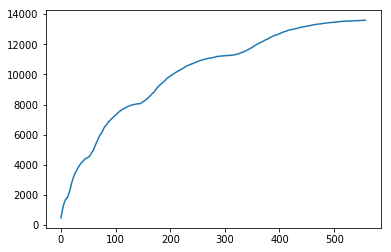

In [16]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_random.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [17]:
df_history.iloc[:, :].to_csv("outputs/%s_random.csv"%dataset)

### Influencers

In [18]:
df_influencer = df_edges.groupby("node_1").count()
seeds = df_influencer.sort_values(["node_2"], ascending=False)[:n_seeds].index.values

df_history, df_infected = simulate_diffusion(seeds, iteration=5)

iteration 0, progress 0/480, infected 495 (1.21%)     
iteration 1, progress 0/6739, infected 6739 (16.54%)     
iteration 1, progress 1000/6739, infected 9577 (23.50%)     
iteration 1, progress 2000/6739, infected 11814 (28.99%)     
iteration 1, progress 3000/6739, infected 13478 (33.08%)     
iteration 1, progress 4000/6739, infected 14640 (35.93%)     
iteration 1, progress 5000/6739, infected 15395 (37.78%)     
iteration 1, progress 6000/6739, infected 15906 (39.04%)     
iteration 2, progress 0/16132, infected 16132 (39.59%)     
iteration 2, progress 1000/16132, infected 16813 (41.26%)     
iteration 2, progress 2000/16132, infected 17699 (43.44%)     
iteration 2, progress 3000/16132, infected 18430 (45.23%)     
iteration 2, progress 4000/16132, infected 19069 (46.80%)     
iteration 2, progress 5000/16132, infected 19585 (48.07%)     
iteration 2, progress 6000/16132, infected 20049 (49.20%)     
iteration 2, progress 7000/16132, infected 20480 (50.26%)     
iteration 2, pr

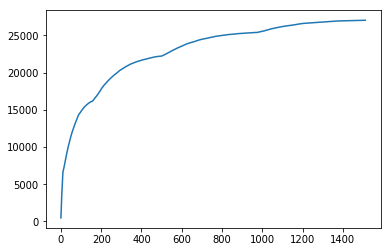

In [19]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [20]:
df_history.iloc[:, :].to_csv("outputs/%s_influencer.csv"%dataset)

### Cluster Random Seeds

In [21]:
n_classes = len(np.unique(df_label.label))

In [22]:
for target in range(n_classes):
    print(target, "cluster size", sum(df_label.label==target))

0 cluster size 1382
1 cluster size 1025
2 cluster size 1841
3 cluster size 1885
4 cluster size 1467
5 cluster size 1097
6 cluster size 1496
7 cluster size 2042
8 cluster size 1533
9 cluster size 1422
10 cluster size 1592
11 cluster size 1500
12 cluster size 826
13 cluster size 1382
14 cluster size 1184
15 cluster size 1411
16 cluster size 1951
17 cluster size 1003
18 cluster size 1801
19 cluster size 1554
20 cluster size 1268
21 cluster size 428
22 cluster size 1000
23 cluster size 1914
24 cluster size 1903
25 cluster size 1585
26 cluster size 1976
27 cluster size 1741
28 cluster size 1614
29 cluster size 1494
30 cluster size 1807
31 cluster size 1414


In [23]:
seeds = []
for target in range(n_classes):
    df_cluster = df_label[df_label.label==target]
    cluster_n_seeds = round(n_seeds * len(df_cluster) / len(df_emb))
    seeds += list(np.random.choice(df_cluster.index, cluster_n_seeds, replace=False))

In [24]:
seeds = [int(i) for i in seeds]
len(seeds)

478

In [25]:
df_history, df_infected = simulate_diffusion(seeds, iteration=5)

iteration 0, progress 0/478, infected 483 (1.19%)     
iteration 1, progress 0/1959, infected 1959 (4.81%)     
iteration 1, progress 1000/1959, infected 4306 (10.57%)     
iteration 2, progress 0/5040, infected 5041 (12.37%)     
iteration 2, progress 1000/5040, infected 6569 (16.12%)     
iteration 2, progress 2000/5040, infected 7834 (19.23%)     
iteration 2, progress 3000/5040, infected 8581 (21.06%)     
iteration 2, progress 4000/5040, infected 9019 (22.13%)     
iteration 2, progress 5000/5040, infected 9210 (22.60%)     
iteration 3, progress 0/9212, infected 9212 (22.61%)     
iteration 3, progress 1000/9212, infected 9934 (24.38%)     
iteration 3, progress 2000/9212, infected 10752 (26.39%)     
iteration 3, progress 3000/9212, infected 11413 (28.01%)     
iteration 3, progress 4000/9212, infected 11941 (29.31%)     
iteration 3, progress 5000/9212, infected 12295 (30.17%)     
iteration 3, progress 6000/9212, infected 12537 (30.77%)     
iteration 3, progress 7000/9212, in

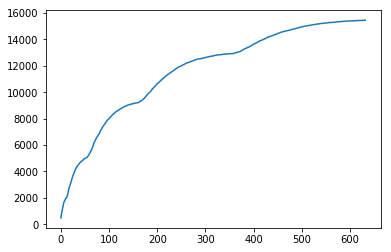

In [26]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_cluster_random.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [27]:
df_history.iloc[:, :].to_csv("outputs/%s_cluster_random.csv"%dataset)

#### Cluster Influencer

In [28]:
seeds = []
for target in range(n_classes):
    idxs = df_label[df_label.label == target].index
    df_cluster = df_edges.loc[list(map(int, idxs))]
    
    df_influencer = df_cluster.groupby("node_1").count()
    
    seeds += list(df_influencer.sort_values(["node_2"], ascending=False)[:int(n_seeds / n_classes)].index.values)
len(seeds)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  after removing the cwd from sys.path.


480

In [29]:
df_history, df_infected = simulate_diffusion(seeds, iteration=5)

iteration 0, progress 0/480, infected 494 (1.21%)     
iteration 1, progress 0/6278, infected 6278 (15.41%)     
iteration 1, progress 1000/6278, infected 9087 (22.30%)     
iteration 1, progress 2000/6278, infected 11469 (28.15%)     
iteration 1, progress 3000/6278, infected 13197 (32.39%)     
iteration 1, progress 4000/6278, infected 14220 (34.90%)     
iteration 1, progress 5000/6278, infected 14954 (36.70%)     
iteration 1, progress 6000/6278, infected 15467 (37.96%)     
iteration 2, progress 0/15550, infected 15550 (38.16%)     
iteration 2, progress 1000/15550, infected 16321 (40.06%)     
iteration 2, progress 2000/15550, infected 17222 (42.27%)     
iteration 2, progress 3000/15550, infected 18025 (44.24%)     
iteration 2, progress 4000/15550, infected 18712 (45.92%)     
iteration 2, progress 5000/15550, infected 19293 (47.35%)     
iteration 2, progress 6000/15550, infected 19815 (48.63%)     
iteration 2, progress 7000/15550, infected 20261 (49.73%)     
iteration 2, pr

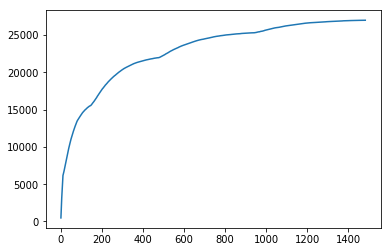

In [30]:
df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
plt.plot(df_sum.values)

In [31]:
df_history.iloc[:, :].to_csv("outputs/%s_cluster_influencer.csv"%dataset)

#### Stratified Sampling by Influence

In [32]:
# df_influencer = df_edges.groupby("node_1").count().sort_values(["node_2"], ascending=False)
# df_influencer["influence"] = 100 * df_influencer.node_2 / len(df_label)
# len(df_influencer)

In [33]:
# n_strata = 32
# _ = plt.hist(df_influencer.node_2, bins=n_strata)
# strata_size, strata_bound = _[0], _[1]
# # plt.close()

In [34]:
# strata_sizes = list(map(round, strata_size))
# strata_bounds = list(map(round, strata_bound))

In [35]:
# seeds = []
# for i in range(n_strata):
#     l, r = strata_bounds[i], strata_bounds[i + 1]
#     strata_size = int(strata_sizes[i])
#     df_strata = df_influencer[(df_influencer.node_2 > l) & (df_influencer.node_2 < r)]
#     cluster_n_seeds = round(n_seeds * strata_size / len(df_influencer))
#     cluster_seeds = list(df_strata[:cluster_n_seeds].index.values)
    
#     seeds += cluster_seeds
# print(len(seeds))

In [36]:
# df_history, df_infected = simulate_diffusion(seeds, iteration=5)

In [37]:
# df_sum = df_history.drop(["label"], axis=1).sum(axis=0)
# df_sum.to_csv("outputs/%s_sum_cluster_influencer.csv"%dataset, header=True)
# plt.plot(df_sum.values)